In [1]:
import sys
sys.path.append("../..")

import logging
logging.getLogger('tensorflow').disabled = True

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import h5py
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
from transport_nets.models import FFJORD

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
file = h5py.File('BeamSamples.h5','r')
joint_samples = np.array(file['Samples/'],dtype=np.float32)
scaler = MinMaxScaler()
scaled_samples = scaler.fit_transform(joint_samples)

NUM_SAMPLES = joint_samples.shape[0]
BATCH_SIZE = 1000
dataset = tf.data.Dataset.from_tensor_slices(scaled_samples)
dataset = dataset.shuffle(buffer_size=NUM_SAMPLES).batch(BATCH_SIZE)

OUTPUT_DIM = 9
NUM_BIJECTORS = 3
NEURON_LIST = [100]

LR = 1e-3
NUM_EPOCHS = 20
opt = tf.keras.optimizers.Adam(LR, epsilon=1e-08)

ffjord = FFJORD(OUTPUT_DIM,
                NUM_BIJECTORS,
                NEURON_LIST,
                trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson)
ffjord.compile(opt)
loss_history = ffjord.fit_custom(dataset,NUM_EPOCHS)
ffjord.training_mode(False)

loss: -33.524 : 100%|██████████| 20/20 [06:10<00:00, 18.51s/it]


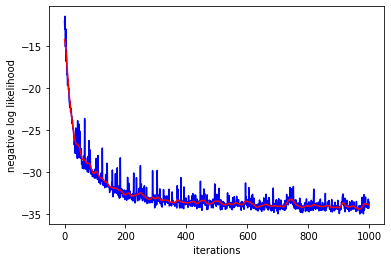

In [3]:
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(loss_history, sigma=5)
plt.plot(loss_history,'b')
plt.plot(ysmoothed, color = 'r')
plt.xlabel('iterations')
plt.ylabel('negative log likelihood');

<Figure size 1080x1080 with 0 Axes>

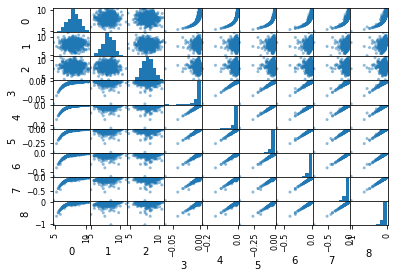

<Figure size 1080x1080 with 0 Axes>

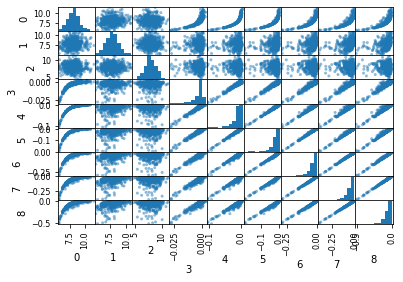

In [4]:
plt.figure(figsize=(15,15))
scatter_matrix(pd.DataFrame(joint_samples[::100,:]))
plt.show()

fig = plt.figure(figsize=(15,15))
x_forward = scaler.inverse_transform(ffjord.sample(500).numpy())
scatter_matrix(pd.DataFrame(x_forward))
plt.savefig('images/Euler-Beam-joint-density-ffjord-scatter.png')
plt.show()

In [ ]:
from transport_nets.mcmc import MetropolisHastings
from transport_nets.mcmc import model_log_prob
num_params = 3
test_values = np.array(file['TestValues'],dtype=np.float32)
m_y_scaled = scaler.transform(np.reshape(test_values,(1,-1)))
y_obs = m_y_scaled[0,num_params:]
init_val = 0.5*tf.ones([3],tf.float32)
b = tf.constant(0.04,tf.float32)
niters = 1000
log_prob_fn = model_log_prob(ffjord,y_given=y_obs)
samples,acc_rate,time_total = MetropolisHastings(init_val,b,niters,log_prob_fn)

 95%|█████████▌| 952/1000 [02:00<00:06,  7.94it/s]

In [ ]:
# unscaling sampled parameters (m1,m2,m3)
data_min = scaler.data_min_[:num_params]
data_max = scaler.data_max_[:num_params]
scale = scaler.scale_[:num_params]
samples_unscaled = samples*(data_max-data_min) + data_min

fig, axs = plt.subplots(1,3,figsize=(15,5))
m1,m2,m3 = tuple(test_values[:num_params])

axs[0].hist(samples_unscaled[:,0],50,density=True)
axs[0].axvline(m1,ymax=0.95,c='r',ls='--',lw=2.0,label='true val')
axs[0].set_xlabel('m1')
axs[0].legend()
#axs[0].set(xlim=(7.9,9.7))

axs[1].hist(samples_unscaled[:,1],50,density=True)
axs[1].axvline(m2,ymax=0.95,c='r',lw=2.0,ls='--',label='true val')
axs[1].set_xlabel('m2')
axs[1].legend()
#axs[1].set(xlim=(7.1,9.3))

axs[2].hist(samples_unscaled[:,2],50,density=True)
axs[2].axvline(m3,ymax=0.95,c='r',lw=2.0,ls='--',label='true val')
axs[2].set_xlabel('m3')
axs[2].legend()
#axs[2].set(xlim=(5.6,11.2))
plt.suptitle('Number of Samples: %d\n Acceptance Rate: %0.3f \n Time: %0.2f s'%(niters,acc_rate,time_total))
plt.subplots_adjust(top=0.85)

plt.savefig('images/FFJORD-MH-Euler_Beam.png')